In [15]:
from google.colab import drive 
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [16]:
# !unzip Airplanes_Annotations.zip

In [17]:
# !unzip Images.zip

In [18]:
import numpy as np
from matplotlib import pyplot as plt 
import tensorflow as tf
import cv2
import os
import pandas as pd 

In [19]:
model=tf.keras.models.load_model('/content/drive/My Drive/Colab Notebooks/Model/RCNN_airplane_model.h5')

In [20]:
svm_image = [];
svm_label = [];

In [21]:
path="Images"
annot="Airplanes_Annotations"

In [23]:
cv2.setUseOptimized(True)
ss=cv2.ximgproc.segmentation.createSelectiveSearchSegmentation()

In [25]:
def get_iou(boxA,boxB):
  x_left_top=max(boxA['x1'],boxB['x1'])
  y_left_top=max(boxA['y1'],boxB['y1'])
  x_bottom_right=min(boxA['x2'],boxB['x2'])
  y_bottom_right=min(boxA['y2'],boxB['y2'])
  
  if x_left_top>=x_bottom_right or y_left_top>=y_bottom_right:
    return 0
  intersection_area=(x_bottom_right-x_left_top)*(y_bottom_right-y_left_top)
  boxA_area=(boxA['x2']-boxA['x1'])*(boxA['y2']-boxA['y1'])
  boxB_area=(boxB['x2']-boxB['x1'])*(boxB['y2']-boxB['y1'])
  return intersection_area/(boxA_area+boxB_area-intersection_area)  

In [27]:

for e,i in enumerate(os.listdir(annot)):
    try:
        if i.startswith("airplane"):
            filename = i.split(".")[0]+".jpg"
            image = cv2.imread(os.path.join(path,filename))
            df = pd.read_csv(os.path.join(annot,i))
            gtvalues=[]
            for row in df.iterrows():
                x1 = int(row[1][0].split(" ")[0])
                y1 = int(row[1][0].split(" ")[1])
                x2 = int(row[1][0].split(" ")[2])
                y2 = int(row[1][0].split(" ")[3]) 
                gtvalues.append({"x1":x1,"x2":x2,"y1":y1,"y2":y2})
                timage = image[x1:x2,y1:y2]
                resized = cv2.resize(timage, (224,224), interpolation = cv2.INTER_AREA)
                svm_image.append(resized)
                svm_label.append([0,1])
            ss.setBaseImage(image)
            ss.switchToSelectiveSearchFast()
            ssresults = ss.process()
            imout = image.copy()
            counter = 0
            falsecounter = 0
            flag = 0
            for e,result in enumerate(ssresults):
                if e < 2000 and flag == 0:
                    for gtval in gtvalues:
                        x,y,w,h = result
                        iou = get_iou(gtval,{"x1":x,"x2":x+w,"y1":y,"y2":y+h})
                        if falsecounter <5:
                            if iou < 0.3:
                                timage = imout[x:x+w,y:y+h]
                                resized = cv2.resize(timage, (224,224), interpolation = cv2.INTER_AREA)
                                svm_image.append(resized)
                                svm_label.append([1,0])
                                falsecounter += 1
                        else :
                            flag = 1
    except Exception as e:
        print(e)
        print("error in "+filename)
        continue

In [28]:

#adding svm to last layer
x =model.get_layer('fc2').output
Y = tf.keras.layers.Dense(2)(x)
final_model = tf.keras.Model(model.input,Y)
final_model.compile(loss='hinge',
              optimizer='adam',
              metrics=['accuracy'])
final_model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)      

In [29]:
hist_final = final_model.fit(np.array(svm_image),np.array(svm_label),batch_size=32,epochs = 20,verbose = 1,
                             shuffle = True,validation_split = 0.05)

Epoch 1/20
232/232 [==============================] - 17s 72ms/step - loss: 0.8669 - accuracy: 0.6854 - val_loss: 0.5995 - val_accuracy: 0.7519
Epoch 2/20
232/232 [==============================] - 15s 67ms/step - loss: 0.5552 - accuracy: 0.7654 - val_loss: 0.6639 - val_accuracy: 0.7008
Epoch 3/20
232/232 [==============================] - 15s 67ms/step - loss: 0.4901 - accuracy: 0.7958 - val_loss: 0.6547 - val_accuracy: 0.7136
Epoch 4/20
232/232 [==============================] - 15s 67ms/step - loss: 0.4367 - accuracy: 0.8185 - val_loss: 0.6294 - val_accuracy: 0.7315
Epoch 5/20
232/232 [==============================] - 15s 67ms/step - loss: 0.3873 - accuracy: 0.8421 - val_loss: 0.6324 - val_accuracy: 0.7596
Epoch 6/20
232/232 [==============================] - 16s 67ms/step - loss: 0.3441 - accuracy: 0.8592 - val_loss: 0.6906 - val_accuracy: 0.7468
Epoch 7/20
232/232 [==============================] - 15s 67ms/step - loss: 0.3181 - accuracy: 0.8701 - val_loss: 0.6015 - val_accuracy:

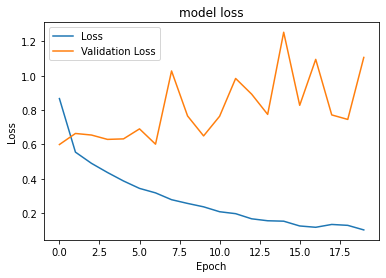

<Figure size 432x288 with 0 Axes>

In [35]:
plt.plot(hist_final.history['loss'])
plt.plot(hist_final.history['val_loss'])
plt.title("model loss")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend(["Loss","Validation Loss"])
plt.show()
plt.savefig('chart loss.png')

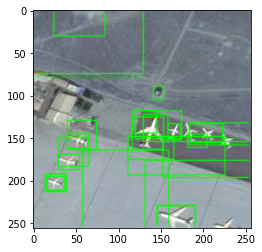

In [33]:

###########  it's time for test a image    ##########
image = cv2.imread(os.path.join(path,'airplane_020.jpg'))
ss.setBaseImage(image)
ss.switchToSelectiveSearchFast()
ssresults = ss.process()

imOut = image.copy()
boxes = []
count = 0
for e,result in enumerate(ssresults):
  if e < 50:
    x,y,w,h = result
    timage = imout[x:x+w,y:y+h]
    resized = cv2.resize(timage, (224,224), interpolation = cv2.INTER_AREA)
    resized = np.expand_dims(resized,axis = 0)
    out = final_model.predict(resized)
    if(out[0][0]<out[0][1]):
      boxes.append([x,y,w,h])
      count+=1

for box in boxes:
    x, y, w, h = box
#     imOut = imOut[x:x+w,y:y+h]
    cv2.rectangle(imOut, (x, y), (x+w, y+h), (0, 255, 0), 1, cv2.LINE_AA)
# plt.figure()
plt.imshow(imOut)